In [1]:
import pypsa
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

n=pypsa.Network()

#Snapshots
n.set_snapshots(value=pd.date_range(freq="h", start="2013-01-01", end="2014-01-01", inclusive='left'))
n.snapshot_weightings[:] *= 8760.0 / n.snapshot_weightings.sum()
Nyears = n.snapshot_weightings.objective.sum() / 8760.0

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages

In [2]:
#I create the bus 

n.madd("Bus", ["onebus"], x=0.1, y=0.2, carrier="AC", v_nom=20)

n.buses

,x,y,carrier,v_nom,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
onebus,0.1,0.2,AC,20.0,,None,1.0,0.0,inf,PQ,


In [3]:

# # #I import a time series for generation 

# with xr.open_dataset(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\time_series\Generation_timeseries\profile_solar.nc') as ds:

#     solar=ds["profile"].transpose("time", "bus").to_pandas()

# #I take just the first column(one bus)

# solar=solar.iloc[:,0:1]
# solar=solar.reindex(n.snapshots)
# #print(solar)

#I connect a generator to the bus "onebus"
# buses=range(1)

#n.madd("Generator", buses, suffix = ' solar', bus = "onebus", p_nom_extendable=True, p_nom_max=350, p_nom_min=280, p_max_pu=solar, p_nom=300, p_set=solar,  marginal_cost=0.001, capital_cost=400)


# # p_nom=1000,  p_nom_extendable=True, carrier="solar", capital_cost=400, efficiency=0.3, marginal_cost=0.001)

In [4]:
# Load yaml files
import yaml

with open(r'config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
 
        print(config)

{'version': '0.0.2', 'tutorial': True, 'logging': {'level': 'INFO', 'format': '%(levelname)s:%(name)s:%(message)s'}, 'scenario': {'simpl': [''], 'll': ['copt'], 'clusters': [6], 'opts': ['Co2L-4H']}, 'countries': ['NG', 'BJ'], 'summary_dir': 'results', 'snapshots': {'start': '2013-03-1', 'end': '2013-03-7', 'inclusive': 'left'}, 'enable': {'retrieve_databundle': True, 'download_osm_data': False, 'build_cutout': True, 'build_natura_raster': True}, 'crs': {'geo_crs': 'EPSG:4326', 'distance_crs': 'EPSG:3857', 'area_crs': 'ESRI:54009'}, 'retrieve_databundle': {'show_progress': True}, 'augmented_line_connection': {'add_to_snakefile': False, 'connectivity_upgrade': 2, 'new_line_type': ['HVAC'], 'min_expansion': 1, 'min_DC_length': 600}, 'cluster_options': {'alternative_clustering': False, 'distribute_cluster': ['load'], 'out_logging': True, 'aggregation_strategies': {'generators': {'p_nom': 'sum', 'p_nom_max': 'sum', 'p_nom_min': 'sum', 'p_min_pu': 'mean', 'marginal_cost': 'mean', 'committab

In [5]:
costs=pd.read_csv(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\costs.csv')

In [6]:
# technologies_path={
#     'onwind': "renewable_profiles/profile_onwind.nc",
#     'solar': "renewable_profiles/profile_solar.nc"
# }

In [7]:
tech_costs=pd.read_csv(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\costs.csv')

idx = pd.IndexSlice

def calculate_annuity(n, r):
    """
    Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20, 0.05) * 20 = 1.6
    """
    if isinstance(r, pd.Series):
        return pd.Series(1 / n, index=r.index).where(
            r == 0, r / (1.0 - 1.0 / (1.0 + r) ** n)
        )
    elif r > 0:
        return r / (1.0 - 1.0 / (1.0 + r) ** n)
    else:
        return 1 / n

In [8]:
tech_costs='C://Users//denis//OneDrive//Desktop//Mini grids//pypsa-distribution//costs.csv'

In [9]:
def load_costs(tech_costs, config, elec_config, Nyears=1):
    """
    set all asset costs and other parameters
    """
    costs = pd.read_csv(tech_costs, index_col=list(range(3))).sort_index()

    # correct units to MW and EUR
    costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
    costs.loc[costs.unit.str.contains("USD"), "value"] *= config["USD2013_to_EUR2013"]

    costs = (
        costs.loc[idx[:, config["year"], :], "value"]
        .unstack(level=2)
        .groupby("technology")
        .sum(min_count=1)
    )

    costs = costs.fillna(
        {
            "CO2 intensity": 0,
            "FOM": 0,
            "VOM": 0,
            "discount rate": config["discountrate"],
            "efficiency": 1,
            "fuel": 0,
            "investment": 0,
            "lifetime": 25,
        }
    )

    costs["capital_cost"] = (
        (
            calculate_annuity(costs["lifetime"], costs["discount rate"])
            + costs["FOM"] / 100.0
        )
        * costs["investment"]
        * Nyears
    )

    costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
    costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]

    costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

    costs = costs.rename(columns={"CO2 intensity": "co2_emissions"})

    costs.at["OCGT", "co2_emissions"] = costs.at["gas", "co2_emissions"]
    costs.at["CCGT", "co2_emissions"] = costs.at["gas", "co2_emissions"]

    costs.at["solar", "capital_cost"] = 0.5 * (
        costs.at["solar-rooftop", "capital_cost"]
        + costs.at["solar-utility", "capital_cost"]
    )

    def costs_for_storage(store, link1, link2=None, max_hours=1.0):
        capital_cost = link1["capital_cost"] + max_hours * store["capital_cost"]
        if link2 is not None:
            capital_cost += link2["capital_cost"]
        return pd.Series(
            dict(capital_cost=capital_cost, marginal_cost=0.0, co2_emissions=0.0)
        )

    max_hours = elec_config["max_hours"]
    costs.loc["battery"] = costs_for_storage(
        costs.loc["battery storage"],
        costs.loc["battery inverter"],
        max_hours=max_hours["battery"],
    )
    costs.loc["H2"] = costs_for_storage(
        costs.loc["hydrogen storage"],
        costs.loc["fuel cell"],
        costs.loc["electrolysis"],
        max_hours=max_hours["H2"],
    )

    for attr in ("marginal_cost", "capital_cost"):
        overwrites = config.get(attr)
        if overwrites is not None:
            overwrites = pd.Series(overwrites)
            costs.loc[overwrites.index, attr] = overwrites

    return costs

In [10]:
costs = load_costs(
    tech_costs,
    config["costs"],
    config["electricity"],
    Nyears,
    )

In [11]:

def attach_wind_and_solar(n, costs, technologies, extendable_carriers):
    
    for tech in technologies:
        
        # with xr.open_dataset(technologies_path[tech]) as ds:
        with xr.open_dataset(f"renewable_profiles/profile_{tech}.nc")as ds:

            if ds.indexes["bus"].empty:
                continue   

            suptech = tech.split("-", 2)[0]


            n.madd(
            "Generator",
            ds.indexes["bus"],
            " " + tech,
            bus=ds.indexes["bus"],
            carrier=tech,
            p_nom_extendable=tech in extendable_carriers["Generator"],
            p_nom_max=ds["p_nom_max"].to_pandas(),
            weight=ds["weight"].to_pandas(),
            marginal_cost=costs.at[suptech, "marginal_cost"],
            capital_cost=costs.at[tech, "capital_cost"],
            efficiency=costs.at[suptech, "efficiency"],
            p_max_pu=ds["profile"].transpose("time", "bus").to_pandas(),
            )


In [12]:
attach_wind_and_solar(
    n,
    costs,
    config["renewable"],
    config["electricity"]["extendable_carriers"],
    )

Index(['0 onwind', '1 onwind', '3 onwind', '4 onwind', '6 onwind', '7 onwind',
       '8 onwind', '9 onwind', '11 onwind', '12 onwind',
       ...
       '247 onwind', '248 onwind', '249 onwind', '250 onwind', '251 onwind',
       '252 onwind', '253 onwind', '254 onwind', '255 onwind', '256 onwind'],
      dtype='object', name='bus', length=222)
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8616, freq=None) are 

In [13]:
n.generators

,bus,carrier,p_nom_extendable,p_nom_max,weight,marginal_cost,capital_cost,efficiency,control,type,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
0 onwind,0,onwind,True,10.954048,0.569543,0.015,109295.569252,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
1 onwind,1,onwind,True,2767.568457,218.413058,0.015,109295.569252,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
3 onwind,3,onwind,True,653.592418,72.784847,0.015,109295.569252,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
4 onwind,4,onwind,True,20317.910033,1974.184973,0.015,109295.569252,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
6 onwind,6,onwind,True,1913.852377,101.438862,0.015,109295.569252,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252 solar,252,solar,True,2400.214828,423.079545,0.010,55064.071419,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
253 solar,253,solar,True,110.273301,15.723475,0.010,55064.071419,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
254 solar,254,solar,True,380.635788,52.001619,0.010,55064.071419,1.0,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [14]:
#I import a time series for load as pandas dataframe
load=pd.read_csv(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\time_series\Load_timeseries\sample_profile.csv', parse_dates=True)
#Used at first, now changed to make it look similar to solar data
# date_index=pd.date_range('01/01/2013', periods=8760, freq='h')
# date_index = pd.DataFrame(date_index, columns=['time'])
# date_index['bus 0']=load_df['bus 0']
# load=date_index
load=load["bus 0"]
load=pd.DataFrame(load)
load = load.set_index([n.snapshots])
import numpy as np
#I create a numpy array 
load_df=np.array(load)


In [15]:

#I connect the load to the bus "onebus"

n.madd("Load", ["MyLoad"], bus=["onebus"], carrier="AC", p_set = load_df)


#Not to have the warning: load_df=load["bus 0"] and p_set=load_df
# n.loads

Index(['MyLoad'], dtype='object', name='Load')

In [16]:
n.generators_t.p_set.plot(color='blue', ylabel='MW')

TypeError: no numeric data to plot

<AxesSubplot: xlabel='snapshot', ylabel='MW'>

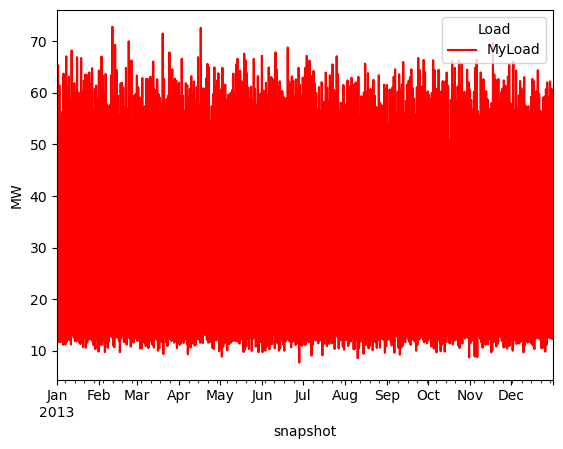

In [ ]:
n.loads_t.p_set.plot(color='red', ylabel='MW')

In [ ]:
#n.madd("StorageUnit", ["mySU"] , bus="onebus",, capital_cost=300)

In [ ]:
n.madd("StorageUnit",["StorUni"], bus="onebus",  p_nom=0.5, marginal_cost=10, inflow=50, p_nom_extendable=True, capital_cost=50, 
       efficiency_dispatch=0.5, cyclic_state_of_charge=True, state_of_charge_initial=1000)

Index(['StorUni'], dtype='object')

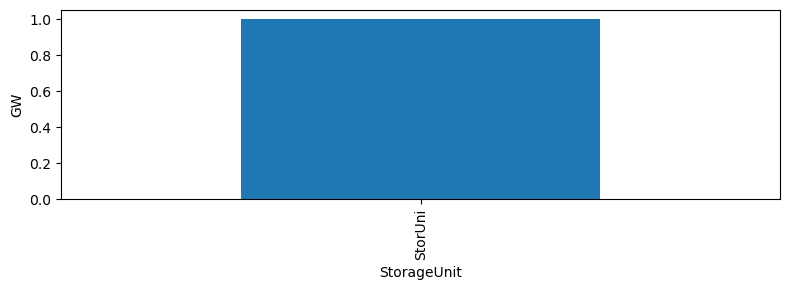

In [ ]:
n.storage_units.state_of_charge_initial.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()

In [ ]:
#I want to see my whole network:

print(n)

PyPSA Network
Components:
 - Bus: 1
 - Generator: 1
 - Load: 1
 - StorageUnit: 1
Snapshots: 8760


In [ ]:
#Optimization
from pypsa.linopf import ilopf

solver_name="gurobi"

n.lopf(n.snapshots, solver_name=solver_name, pyomo=False)


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-07
Read LP format model from file C:\Users\denis\AppData\Local\Temp\pypsa-problem-z0_ozool.lp
Reading time = 0.49 seconds
obj: 87600 rows, 43803 columns, 170564 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 87600 rows, 43803 columns and 170564 nonzeros
Model fingerprint: 0x6e5c4c79
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e-03, 4e+02]
  Bounds range     [5e+01, 1e+05]
  RHS range        [8e+00, 7e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51571 rows and 11896 columns
Presolve time: 0.40s
Presolved: 36029 rows, 31907 columns, 111430 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 9.243e+04
 Factor NZ  : 3.921e+05 (roughly 30 MB of memory)
 Factor Ops : 4.870

INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+06


('ok', 'optimal')

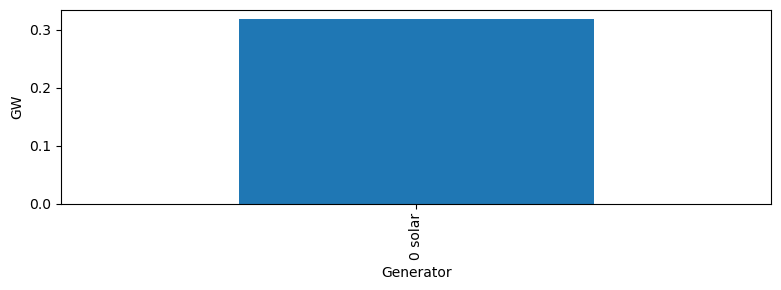

In [ ]:
n.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()

In [ ]:
print(n.storage_units.p_nom_opt)

StorageUnit
StorUni    264.035804
Name: p_nom_opt, dtype: float64


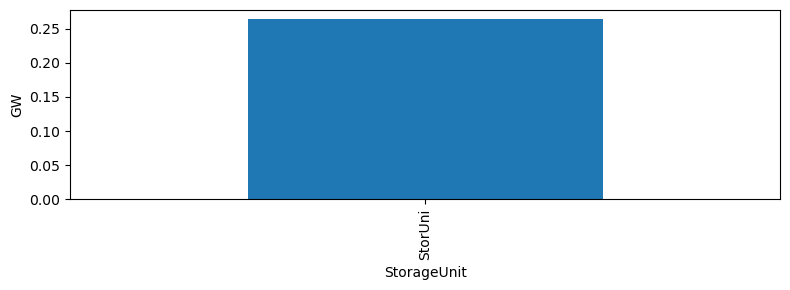

In [ ]:
n.storage_units.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()

In [ ]:
n.storage_units_t.keys()

dict_keys(['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'marginal_cost', 'state_of_charge_set', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 'mu_lower', 'mu_state_of_charge_set'])

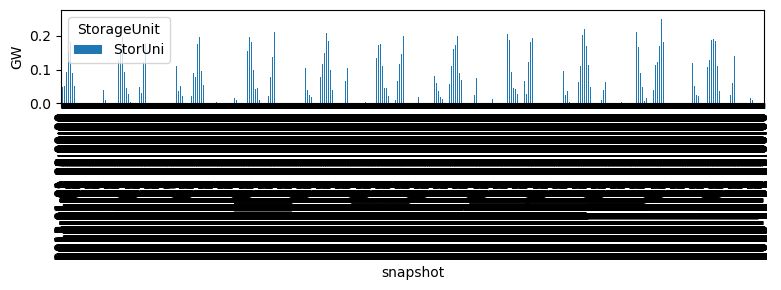

In [ ]:
n.storage_units_t.state_of_charge.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()


In [ ]:
n.storage_units

,bus,p_nom,marginal_cost,inflow,p_nom_extendable,capital_cost,efficiency_dispatch,cyclic_state_of_charge,state_of_charge_initial,control,...,carrier,build_year,lifetime,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,max_hours,efficiency_store,standing_loss,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
StorUni,onebus,0.5,10.0,50.0,True,50.0,0.5,True,1000.0,PQ,...,,0,inf,False,NaN,True,1.0,1.0,0.0,264.035804


In [ ]:
n.iplot()

{'data': [{'x': Bus
   onebus    0.1
   Name: x, dtype: float64,
   'y': Bus
   onebus    0.2
   Name: y, dtype: float64,
   'text': Index(['Bus onebus'], dtype='object', name='Bus'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'opacity': 1,
   'marker': {'color': 'cadetblue', 'size': 10}}],
 'layout': {'title': '',
  'hovermode': 'closest',
  'showlegend': False,
  'shapes': []}}

In [ ]:
n.buses

,x,y,carrier,v_nom,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,generator
Bus,,,,,,,,,,,,
onebus,0.1,0.2,AC,20.0,,None,1.0,0.0,inf,Slack,0,0 solar
